# 5-1. Variational Quantum Eigensolver（VQE）アルゴリズム

https://dojo.qulacs.org/ja/latest/notebooks/5.1_variational_quantum_eigensolver.html

## 量子ゲートの準備

In [1]:
import numpy as np

#パウリ演算子を準備する。
nqubits = 2
pI = np.array([[1.0+0.0j, 0+0.0j], [0.0+0.0j, 1.0+0.0j]])
pX = np.array([[0.0+0.0j, 1+0.0j], [1.0+0.0j, 0.0+0.0j]])
pZ = np.array([[1.0+0.0j, 0+0.0j], [0.0+0.0j, -1.0+0.0j]])
pY = np.array([[0.0+0.0j, 0-1.0j], [0.0+1.0j, 0.0+0.0j]])
pHad = (pX+pZ)/np.sqrt(2)
pP0 = (pI+pZ)/2
pP1 = (pI-pZ)/2

In [2]:
#パウリ演算子を1量子ゲートに変換する。
X=[1]*(nqubits)
Y=[1]*(nqubits)
Z=[1]*(nqubits)
H=[1]*(nqubits)
P0=[1]*(nqubits)
P1=[1]*(nqubits)

for i in range(nqubits):
    for j in range(nqubits):
        if(i != j):
            X[i] = np.kron(pI,X[i])
            Y[i] = np.kron(pI,Y[i])
            Z[i] = np.kron(pI,Z[i])
            H[i] = np.kron(pI,H[i])
            P0[i] = np.kron(pI,P0[i])
            P1[i] = np.kron(pI,P1[i])
        else:
            X[i] = np.kron(pX,X[i])
            Y[i] = np.kron(pY,Y[i])
            Z[i] = np.kron(pZ,Z[i])
            H[i] = np.kron(pHad,H[i])
            P0[i] = np.kron(pP0,P0[i])
            P1[i] = np.kron(pP1,P1[i])
Ide = np.eye(2**nqubits)

In [3]:
X

[array([[0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]]),
 array([[0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
        [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]])]

In [4]:
#2量子ゲートを準備する。
CZ = [[0 for i in range(nqubits)] for j in range(nqubits)]
CX = [[0 for i in range(nqubits)] for j in range(nqubits)]

for i in range(nqubits):
    for j in range(nqubits):
        CZ[i][j]= (P0[i]+np.dot(P1[i],Z[j]))
        CX[i][j]= (P0[i]+np.dot(P1[i],X[j]))

In [5]:
CZ

[[array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
         [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j],
         [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j],
         [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]]),
  array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
         [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
         [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j],
         [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]])],
 [array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
         [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
         [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j],
         [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]]),
  array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
         [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
         [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
         [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]])]]

In [6]:
#変分量子ゲート(X,Y,Zに関する回転の角度を指定できるゲート)を準備する。
from scipy.linalg import expm
def RX(target,angle):
    return expm(-0.5*angle*1.j*X[target])
def RY(target,angle):
    return expm(-0.5*angle*1.j*Y[target])
def RZ(target,angle):
    return expm(-0.5*angle*1.j*Z[target])

In [9]:
#初期状態|0000・・・0>を準備する。
def StateZeros(nqubits):
    State = np.zeros(2**nqubits)
    State[0]=1
    return State

## ハミルトニアンを準備する

任意のハミルトニアン（エルミート行列）は、パウリ行列を用いて表すことができる。

In [10]:
M = (-3.8505 * Ide  - 0.2288 * X[1] - 1.0466 * Z[1] - 0.2288 * X[0] +  0.2613 * np.dot(X[0],X[1]) + \
     0.2288 *np.dot(X[0],Z[1]) - 1.0466*Z[0] + 0.2288* np.dot(Z[0],X[1]) +  0.2356 * np.dot(Z[0],Z[1]) )/2
M

array([[-2.85405+0.j,  0.     +0.j,  0.     +0.j,  0.13065+0.j],
       [ 0.     +0.j, -2.04305+0.j,  0.13065+0.j, -0.2288 +0.j],
       [ 0.     +0.j,  0.13065+0.j, -2.04305+0.j, -0.2288 +0.j],
       [ 0.13065+0.j, -0.2288 +0.j, -0.2288 +0.j, -0.76085+0.j]])

## 量子回路を準備する

In [13]:
def TwoQubitPQC(phi):
    state = StateZeros(2)
    state = np.dot(RX(0,phi[0]),state)
    state = np.dot(RZ(0,phi[1]),state)
    state = np.dot(RX(1,phi[2]),state)
    state = np.dot(RZ(1,phi[3]),state)
    state = np.dot(CX[1][0],state)
    state = np.dot(RZ(1,phi[4]),state)
    state = np.dot(RX(1,phi[5]),state)
    return state

## 量子状態のエネルギー期待値を測定する

In [14]:
def ExpectVal(Operator,State):
    BraState = np.conjugate(State.T) #列ベクトルを行ベクトルへ変換
    tmp = np.dot(BraState,np.dot(Operator,State)) #行列を列ベクトルと行ベクトルではさむ
    return np.real(tmp) #要素の実部を取り出す

## エネルギー期待値の最小化

[0.21466527 0.39849548 0.48989918 0.25602293 0.90674031 0.41392478]


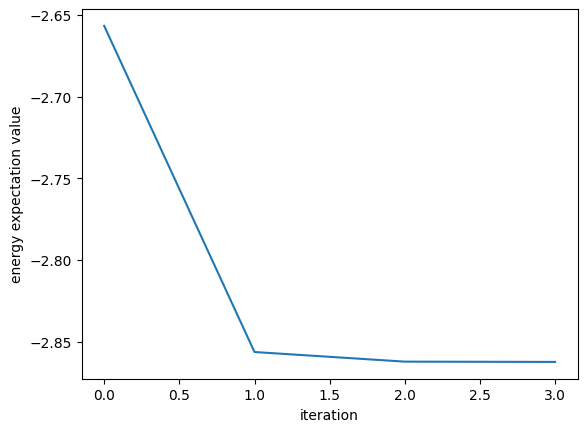

In [18]:
import scipy.optimize
import matplotlib.pyplot as plt

def cost(phi):
    return ExpectVal(M, TwoQubitPQC(phi))

cost_val = [] #コスト関数の変化を保存するための関数

#この関数がiteration ごとに呼ばれる。
def callback(phi):
    global cost_val
    cost_val.append(cost(phi))

n_param = 6
init = np.random.rand(n_param)
print(init)
callback(init)
res = scipy.optimize.minimize(cost, init,
                              method='Powell',
                              callback=callback)
plt.plot(cost_val)
plt.xlabel("iteration")
plt.ylabel("energy expectation value")
plt.show()

ハミルトニアンを対角化して得られた厳密なエネルギーと比べることで、VQE によって算出された値が正しいか検証してみよう。

In [19]:
M

array([[-2.85405+0.j,  0.     +0.j,  0.     +0.j,  0.13065+0.j],
       [ 0.     +0.j, -2.04305+0.j,  0.13065+0.j, -0.2288 +0.j],
       [ 0.     +0.j,  0.13065+0.j, -2.04305+0.j, -0.2288 +0.j],
       [ 0.13065+0.j, -0.2288 +0.j, -0.2288 +0.j, -0.76085+0.j]])

In [48]:
import scipy.linalg
l, P = scipy.linalg.eigh(M)
print(l[0]) #最小固有値
print(cost(res.x)) #VQEの結果

-2.8626207640766816
-2.862397849167962


Powell法で算出した固有値と一致はしていないものの、小数第3位まで同じであるので、殆ど正しいと言っていいだろう。

次に回路の出力にノイズが存在するケースでも検証してみよう。NISQでは出力にエラー（ノイズ）がのることが避けられないため、ノイズありでもアルゴリズムが動くのか・どの程度のノイズまでなら耐えられるのかといった検証は非常に重要である。

In [49]:
def cost(phi):
    return ExpectVal(M,TwoQubitPQC(phi))+np.random.normal(0,0.01)

def callback(phi):
    global cost_val
    cost_val.append(cost(phi))

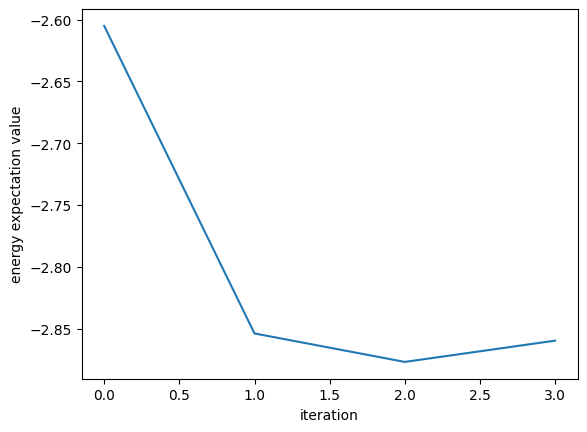

-2.8443296057945964


In [50]:
cost_val=[] # コスト関数の履歴
init = np.random.rand(6)
callback(init)
res = scipy.optimize.minimize(cost, init,
                              method='Powell',
                              callback=callback)
plt.plot(cost_val)
plt.xlabel("iteration")
plt.ylabel("energy expectation value")
plt.show()
print(cost(res.x))